In [1]:
"""
Created on Saturday Januyaray 04, 2025

@author: AFTAB HASSAN

"""
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning) # setting ignore as a parameter and further adding category
warnings.simplefilter('ignore')
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

import torch
from gluonts.torch.distributions.studentT import StudentTOutput
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.evaluation import Evaluator, make_evaluation_predictions
from lag_llama.gluon.estimator import LagLlamaEstimator

import math
import time
import os
import itertools
from itertools import islice
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [2]:
def CalMape(actual_data, fit_data, term):
    #term  = 12
    lastActualData = actual_data[-term:]
    lastFitData    = fit_data[-term:]        
    i = 0
    count = 0
    ape = 0
    for actualVal in lastActualData:
        #print(actualVal,lastFitData[i])
        if(actualVal != 0):
            val = (abs(actualVal - lastFitData[i])/actualVal)*100
            #val=abs(val)
            #print(val)
            if(val <100):
                count = count + 1
                ape  = ape + val       
        i = i+1
        
    if(count!=0):
        mape_cal = (ape/count)
    else:
        mape_cal=99
            
    if(math.isnan(mape_cal)):        
            return 0
    else:      
        return mape_cal

In [3]:
def CalWMape(actual_data, fit_data, term):
    lastActualData = actual_data[-term:]
    lastFitData    = fit_data[-term:]        
    i=0
    count = 0
    sump_actual=0
    sum_actual_fitted=0
    
    for actualVal in lastActualData:
        if(actualVal != 0):
            sum_actual_fitted += abs(actualVal - lastFitData[i])
            sump_actual +=actualVal
            count = count + 1        
        i = i+1     
          
    if(count!=0):
        wmape_cal = (sum_actual_fitted/sump_actual)*100
    else:
        wmape_cal=99        
     
    if(np.isnan(wmape_cal).any()):        
        return 0
    else:      
        return wmape_cal  

In [4]:
def mape_recalculate(temp_result):  
    temp_wmape=[]
    temp=[]
    i = 0
    count = 0
    ape = 0
    for item in temp_result:
        #print(actualVal,lastFitData[i])
        temp_wmape.append(item[5])
        actualVal=item[8]
        forecastVal=item[7]
        if(actualVal != 0):
            val = (abs(actualVal - forecastVal)/actualVal)*100
            if(val <100):
                count = count + 1
                ape  = ape + val       
        i = i+1
        
    if(count!=0):
        mape_cal = (ape/count)
    else:
        mape_cal=99
            
    if(math.isnan(mape_cal)):        
            mape_cal=0

    #print(mape_cal)
    avg_wmape=sum(temp_wmape)/len(temp_wmape)
    for x in temp_result:
        x[5]=round(avg_wmape,3)
        x[6]=round(mape_cal,3)
        temp.append(x)
    return temp

In [5]:
output=[]
temp_output=[]
# Load Data 

df = pd.read_csv('input/sales_data1.csv')
col=['ALL_DATE','Region','SKU','Type','QTY']
df.columns=col
df["ALL_DATE"]=pd.to_datetime(df["ALL_DATE"],format="%d-%m-%Y")
df.set_index("ALL_DATE", inplace=True)

In [6]:
# display head data
df.head()

,Region,SKU,Type,QTY
ALL_DATE,,,,
2021-01-01,Hyderabad,SKU1,Sales,768
2021-02-01,Hyderabad,SKU1,Sales,803
2021-03-01,Hyderabad,SKU1,Sales,879
2021-04-01,Hyderabad,SKU1,Sales,132
2021-05-01,Hyderabad,SKU1,Sales,123


In [7]:
# display tail data
df.tail()

,Region,SKU,Type,QTY
ALL_DATE,,,,
2023-08-01,Hyderabad,SKU1,Sales,2717
2023-09-01,Hyderabad,SKU1,Sales,2929
2023-10-01,Hyderabad,SKU1,Sales,3100
2023-11-01,Hyderabad,SKU1,Sales,3339
2023-12-01,Hyderabad,SKU1,Sales,3729


In [8]:
df.describe()

,QTY
count,36.000000
mean,1265.944444
std,941.589566
min,123.000000
25%,561.500000
50%,898.000000
75%,1821.250000
max,3729.000000


In [9]:
df.shape

(36, 4)

In [10]:
# display column name
print(df.columns)

df.drop(["Type"],axis=1,inplace=True,errors="ignore")

Index(['Region', 'SKU', 'Type', 'QTY'], dtype='object')


In [11]:
df.shape

(36, 3)

In [12]:
df['QTY'].describe()

count      36.000000
mean     1265.944444
std       941.589566
min       123.000000
25%       561.500000
50%       898.000000
75%      1821.250000
max      3729.000000
Name: QTY, dtype: float64

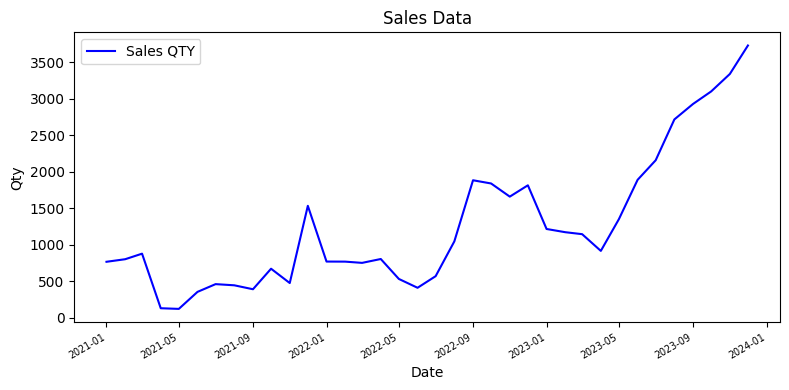

In [13]:
# Plotting the results for train dataset
plt.figure(figsize=(8, 4))
plt.plot( df.index, df['QTY'], label='Sales QTY', color='blue')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.title('Sales Data')
plt.xticks(rotation=90, fontweight='light',  fontsize='x-small',)
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.legend()
plt.show()

In [14]:
def evaluate_arima_order (data):
    # Define the p, d and q parameters to take any value between 0 and 2
    p = range(1,4)
    d = range(1,3)
    q = range(1,4)
        
    # Generate all different combinations of p, d and q triplets
    pdq = list(itertools.product(p, d, q))
    #print(pdq)
        
    best_aic = np.inf
    best_pdq = None
    temp_model = None
    for param in pdq:   
        temp_model = ARIMA(data,order=param)
        results = temp_model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param 
    print("Best ARIMA {} model - AIC:{}".format(best_pdq,best_aic))  
      
    return best_pdq

In [15]:
def ARIMA_Model(step,orig_data,best_pdq,train_data,test_data,sales_column):      
        
    mod = ARIMA(orig_data, order=best_pdq)
    res = mod.fit()  
    pred_data = res.predict()  
        
    forecasted_value = res.forecast(steps = step)        
    #print("forecasted Value",forecasted_value)
    
    wmape=round(CalMape(orig_data,pred_data,len(pred_data)),3)
    print("ARIMA Train MAPE : ",wmape)

    mape=round(CalMape(test_data[sales_column],forecasted_value,len(forecasted_value)),3)
    print("ARIMA Test MAPE : ",mape)
    return np.round(forecasted_value,3),mape,wmape,pred_data

In [16]:
def evaluate_sarima_order (data):
    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0, 2)
    # Generate all different combinations of p, d and q triplets
    pdq = list(itertools.product(p, d, q))        
    # Generate all different combinations of seasonal p, q and q triplets
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
        
    best_aic = np.inf
    best_pdq = None
    best_seasonal_pdq = None
    temp_model = None
    for param in pdq:   
        for param_seasonal in seasonal_pdq: 
            temp_model = SARIMAX(data,order=param,seasonal_order = param_seasonal,enforce_invertibility=True,enforce_stationarity=False)
            results = temp_model.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
    print("Best ARIMA {} x {} model - AIC:{}".format(best_pdq,best_seasonal_pdq,best_aic)) 
    
    return  best_pdq,best_seasonal_pdq

In [17]:
def SARIMA_Model(step,orig_data,best_pdq,best_seasonal_pdq,train_data,test_data,sales_column):        
        
    mod = SARIMAX(orig_data,order=best_pdq,seasonal_order=best_seasonal_pdq)
    res = mod.fit(disp=False)     
    pred_data = res.predict()    
        
    forecasted_value = res.forecast(steps = step)        
    #print("forecasted Value",forecasted_value)
   
    wmape=round(CalMape(orig_data,pred_data,len(pred_data)),3)
    print("SARIMA Train MAPE : ",wmape)
    
    mape=round(CalMape(test_data[sales_column],forecasted_value,len(forecasted_value)),3)
    print("SARIMA Test MAPE : ",mape)
    return np.round(forecasted_value,3),mape,wmape,pred_data


In [18]:
def Holt_Winters_Model(step,orig_data,model_type,train_data,test_data,sales_column):  
    #print("In holtz winter")      
    if(model_type=='add'):
        mod = ExponentialSmoothing(orig_data , initialization_method= 'legacy-heuristic',seasonal_periods=12,trend=None, seasonal='add')
    else:
        mod = ExponentialSmoothing(orig_data ,initialization_method= 'legacy-heuristic',seasonal_periods=12 ,trend='mul',seasonal='mul')
        
    res = mod.fit(optimized=True,use_brute=True)  
    #print(res.summary())
   
    pred_data = res.fittedvalues
    
    forecasted_value = res.forecast(steps = step)
    #print("forecasted Value",forecasted_value)
    
    wmape=round(CalMape(orig_data,pred_data,len(pred_data)),3)
    print("Train Holt_Winters_Model MAPE : ",wmape)
    
    mape=round(CalMape(test_data[sales_column],forecasted_value,len(forecasted_value)),3)
    print("Test Holt_Winters_Model MAPE : ",mape)
    return np.round(forecasted_value,3),mape,wmape,pred_data


In [19]:
def save_output(start_year,area_code,psku_code,model_name,mape,wmape,forecasted_value,orig_data,inc_loop,sales_qty):
    i=inc_loop
    negFlag=1
    sales_qty=float(sales_qty)
    #print("Sales QTY = ",sales_qty)
    for fvalue in forecasted_value:                      
        if(fvalue<0):
            negFlag=0
            break            
    
    if(negFlag==1):            
        for fvalue in forecasted_value: 
            fvalue=round(float(fvalue),3)       
            #i+=1
            if(math.isnan(fvalue)==True):  
                #print(np.mean(orig_data))
                MaxFvalue = round(float(np.mean(orig_data)),3)
                temp_output.append([start_year,i,area_code,psku_code,model_name,0,0,MaxFvalue,sales_qty])
            else:
                temp_output.append([start_year,i,area_code,psku_code,model_name,round(float(wmape),3),round(float(mape),3),fvalue,sales_qty])
    else:
        for fvalue in forecasted_value:  
            fvalue=round(float(fvalue),3)              
            #i+=1
            if(math.isnan(fvalue)==True or fvalue<0): 
                #print(">>>>>>>",np.mean(orig_data))
                MaxFvalue = round(float(np.mean(orig_data)),3)                
                temp_output.append([start_year,i,area_code,psku_code,model_name,0,0,MaxFvalue,sales_qty])
            else:
                temp_output.append([start_year,i,area_code,psku_code,model_name,round(float(wmape),3),round(float(mape),3),fvalue,sales_qty])
    


In [20]:
def forcast_output_CSV(output,sales_column):
    #print("Result is writing into csv")
    
    data=[]   

    for x in output:
        #print ('x=',x)   
        start_year=x[0]
        variable='X'+str(x[1])
        region = x[2]
        sku_name=x[3]     
        model_name=x[4] 
        accuracy_wmape=x[5]
        accuracy_mape=x[6]      
        value=x[7]
        sales_qty=x[8]

        #print(fc_model_code,sku_name,model_name,accuracy_me,accuracy_rsme,accuracy_mae,accuracy_mpe,accuracy_mape,accuracy_mase,variable,value)
        data.append([start_year,region,sku_name,model_name,accuracy_wmape,accuracy_mape,variable,value,sales_qty])
        
    fp=open("output/ForecastedResult_"+sales_column+".csv","w")                                        

    header='Star Year'+','+'Region'+','+'SKU'+','+'Model Name'+','+'Overall MAPE'+','+'Test MAPE'+','+'Steps'+','+'Forecast QTY' +','+'Sales QTY'
            
    fp.writelines(header)
    fp.write('\n')
    
    for x in data:
        #print ('x=',x)
        temp=""         
        for i in range(len(x)-1):
            temp=temp+str(x[i])+','
            
        temp=temp+str(x[len(x)-1])
    
        fp.writelines(temp)
        fp.write('\n')
    
    fp.close()


In [21]:
def fitted_output_CSV(temp_output,sales_column):
    print("Result is writing into fitted_output_CSV")
        
    fp=open("output/FittedResult_"+sales_column+".csv","w")                                        

    header='Date'+','+'Region'+','+'SKU'+','+'Model Name'+','+'Sales QTY' +','+'Fitted QTY'
            
    fp.writelines(header)
    fp.write('\n')
    
    for x in temp_output:
        #print ('x=',x)
        temp=""         
        for i in range(len(x)-1):
            temp=temp+str(x[i])+','
            
        temp=temp+str(x[len(x)-1])
    
        fp.writelines(temp)
        fp.write('\n')
    
    fp.close()

In [22]:
def _get_lag_llama_predictions(dataset, prediction_length, num_samples=100):
    # Load the checkpoint with map_location set to 'cpu'
    ckpt = torch.load("lag-llama.ckpt", map_location=torch.device('cpu'))
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    # Initialize the estimator with the required arguments
    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=32,

        # scaling="mean",
        nonnegative_pred_samples=True,
        aug_prob=0,
        lr=0.0005,
        
        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],

        # linear positional encoding scaling
        # rope_scaling={
        #     "type": "linear",
        #     "factor": max(1.0, (32 + prediction_length) / estimator_args["context_length"]),
        # },
        
        batch_size=16,
        num_parallel_samples=num_samples,
        trainer_kwargs = {"max_epochs": 200,}, # <- lightning trainer arguments
    )


    # Create the lightning module, transformation, and predictor
    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    # Generate forecasts and time series predictions
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset, predictor=predictor, num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss ,predictor

In [23]:
def _get_lag_llama_dataset(dataset):
    # avoid mutations
    dataset = dataset.copy()
    #print(dataset)
    # convert numerical columns to `float32`
    for col in dataset.columns:
        if dataset[col].dtype != "object" and not pd.api.types.is_string_dtype(
            dataset[col]
        ):
            dataset[col] = dataset[col].astype("float32")

    # create a `PandasDataset`
    backtest_dataset = PandasDataset(dict(dataset))
    return backtest_dataset

In [24]:
def Lagllama_Model(step,train_data2,test_data,sales_column,time_freq):
    df =train_data2.copy()
    #print("sales_column : ",sales_column)
    df=df[[sales_column]]

    backtest_dataset = _get_lag_llama_dataset(dataset=df)
    #print(backtest_dataset)
    prediction_length = step  # prediction length
    num_samples = len(df) # 36 is sampled from the distribution for each timestep
    forecasts, tss,model_fit = _get_lag_llama_predictions(
    backtest_dataset, prediction_length, num_samples
    )
    # Extract forecasted mean values
    forecast_index = pd.date_range(start=df.index[-1], periods=prediction_length+1, freq=time_freq)[1:]

    
    forecast_values = [forecast.mean for forecast in forecasts]
    forecast_df = pd.DataFrame(forecast_values[0], index=forecast_index, columns=['Forecast'])
    
    forecasted_value=forecast_df['Forecast'].values
    print("Lag-llama forecasted Value",np.round(forecasted_value,3))
    
    test_data2=np.array(test_data[sales_column])

    fitted_values=tss[0].values.reshape(1,-1)[0]
    
    mae = mean_absolute_error(test_data2, forecasted_value)
    mape = CalMape(test_data2, forecasted_value, len(forecasted_value))
    rmse = np.sqrt(mean_squared_error(test_data2, forecasted_value))
    r2 = r2_score(test_data2, forecasted_value)
    print("Lag LLama : ",mae,mape,rmse,r2)

    return np.round(forecasted_value,3),fitted_values,mae,mape,rmse,r2

In [25]:
sales_column='QTY'
output=[]
sales_fitted_values=[]
monthstep=3
tarin_ratio=0.1
data_type_univariate=True
# if(data_type_univariate==True):
#     #MultiModelInfo={'ARIMA':3,'SARIMA':3,'HWADD':3,'HWMUL':3,'RFR':3,'XGBR':3,'EXPERT':3,'LSTM':3,'RNN':3,'CNN':3,'Lagllama':3}
#     MultiModelInfo={'Lagllama':3}
# else:
#     MultiModelInfo={'RFR':3,'XGBR':3,'EXPERT':3,'LSTM':3,'RNN':3,'CNN':3}
    
MultiModelInfo={'ARIMA':3,'SARIMA':3,'HWADD':3,"Lagllama":3}
for sel_model_name,month_step in MultiModelInfo.items():
    model_on_off=[0,0,0,0,0,0,0,0,0,0,0]
    #model_on_off=[1,1,1,1,1,1,1,1,1,1,1]
    print("sel_model_name = ",sel_model_name)
    monthstep = month_step        
    if(sel_model_name=="ARIMA"):
        model_on_off[0]=1
    elif(sel_model_name=="SARIMA"):
        model_on_off[1]=1
    elif(sel_model_name=="HWADD"):
        model_on_off[2]=1
    elif(sel_model_name=="HWMUL"):
        model_on_off[3]=1   
    elif(sel_model_name=="Lagllama"):
        model_on_off[4]=1
    elif(sel_model_name=="RFR"):
        model_on_off[5]=1
    elif(sel_model_name=="XGBR"):
        model_on_off[6]=1
    elif(sel_model_name=="EXPERT"):
        model_on_off[7]=1   
    elif(sel_model_name=="LSTM"):
        model_on_off[8]=1
    elif(sel_model_name=="RNN"):
        model_on_off[9]=1
    elif(sel_model_name=="CNN"):
        model_on_off[10]=1
    else:
        model_on_off[0]=1    
     
    print("Selected Model is executing",sel_model_name,model_on_off)
    area= set(list(df["Region"]))
    
    for area_code in area:    
        if(pd.isna(area_code)):
            continue
        df_area_temp=df[df['Region'].isin([area_code])]
        psku = set(list(df_area_temp["SKU"]))     
        for psku_code in psku:
            print(area_code,psku_code)    
            df_temp=df_area_temp[df_area_temp['SKU'].isin([psku_code])]             
            test_length=int(len(df_temp)*tarin_ratio)
            train_length=len(df_temp)-test_length
            print("Train Data Points  ",train_length)
            print("Test Data Points  ",test_length)
            loop_Step=0
            temp_output=[]
            for k in range(0,test_length,1):
                train_data=df_temp.iloc[:train_length+k,]
                test_data=df_temp.iloc[train_length+k:train_length+k+1,]
                #print("k = ",k)
                datapoint=len(train_data)                
                #print("Train Data Points  ",len(train_data))
                #print("Test Data Points  ",len(test_data))
                if(datapoint==0 ):            
                    continue 
                sales_qty=np.asarray(test_data[sales_column])[0]
                #print(sales_qty)
                product=list(train_data['SKU'])[0]
                #print(train_data)     
                start_date=list(train_data.index)[0]
                #print("Start Date ",start_date)
                start_year = start_date.year
                #print("Start Year ",start_year)            
                
                orig_data = np.asarray(train_data[sales_column])  
                date_data = list(train_data.index)
                zerocount = (train_data[sales_column] <= 0).sum()
                #print(orig_data)  
                #step=len(test_data)       
                step=1
                loop_Step=loop_Step+1
                #print(datapoint,zerocount,zerocount<=int(datapoint*0.80)) 
                
                # result = seasonal_decompose(orig_data, model='additive', period=12)
                # result.plot()
                # plt.show()                
                    
                if(model_on_off[0]==1):
                    model_name="ARIMA" 
                    print(model_name," Model is executing")
                    best_pdq=evaluate_arima_order(orig_data)
                    best_pdq=(1,2,1)                       
                    forecasted_value,mape,wmape,fittedValue = ARIMA_Model(step,orig_data,best_pdq,train_data,test_data,sales_column)
                    #print("ARIMA Model QTY data forecasted value : ",forecasted_value)
                    save_output(start_year,area_code,psku_code,model_name,mape,wmape,forecasted_value,orig_data,loop_Step,sales_qty)
                if(model_on_off[1]==1):
                    model_name="SARIMA" 
                    #print(model_name," Model is executing")
                    #best_pdq,best_seasonal_pdq=evaluate_sarima_order(orig_data)
                    best_pdq,best_seasonal_pdq=(1,1,1),(1,1,1,12)                       
                    forecasted_value,mape,wmape,fittedValue = SARIMA_Model(step,orig_data,best_pdq,best_seasonal_pdq,train_data,test_data,sales_column)
                    #print("SARIMA Model QTY data forecasted value : ",forecasted_value)
                    save_output(start_year,area_code,psku_code,model_name,mape,wmape,forecasted_value,orig_data,loop_Step,sales_qty)
                if(model_on_off[2]==1):
                    model_name="HWADD"    
                    #print(model_name," Model is executing")
                    forecasted_value,mape,wmape,fittedValue = Holt_Winters_Model(step,orig_data,'add',train_data,test_data,sales_column)                
                    #print("HOLT Winters Additive Model QTY data forecasted value : ",forecasted_value,mape,wmape)
                    save_output(start_year,area_code,psku_code,model_name,mape,wmape,forecasted_value,orig_data,loop_Step,sales_qty)
                if(model_on_off[3]==1):            
                    model_name="HWMUL"    
                    #print(model_name," Model is executing")
                    forecasted_value,mape,wmape,fittedValue = Holt_Winters_Model(step,orig_data,'mul',train_data,test_data,sales_column)                
                    #print("HOLT Winters Multiplicative Model QTY data forecasted value : ",forecasted_value)
                    save_output(start_year,area_code,psku_code,model_name,mape,wmape,forecasted_value,orig_data,loop_Step,sales_qty)
                if(model_on_off[4]==1):            
                    model_name="Lagllama"    
                    print(model_name," Model is executing")
                    time_freq='MS'
                    forecasted_value,fittedValue,mae,mape,rmse,r2 = Lagllama_Model(step,train_data,test_data,sales_column,time_freq)                
                    #print("HOLT Winters Multiplicative Model QTY data forecasted value : ",forecasted_value)
                    save_output(start_year,area_code,psku_code,model_name,mape,mape,forecasted_value,orig_data,loop_Step,sales_qty)
                
                if(k==0):         
                    for indx in range(len(orig_data)):
                        # try:
                        #     ftValue = fittedValue[indx]
                        # except IndexError:
                        #     ftValue = None                    
                        sales_fitted_values.append([date_data[indx],area_code,psku_code,model_name,orig_data[indx],fittedValue[indx]])
            #print(temp_output)
            temp_output=mape_recalculate(temp_output)
            for item in temp_output:
                output.append(item)
print("Forecast generated successfully!")
forcast_output_CSV(output,sales_column)

sel_model_name =  ARIMA
Selected Model is executing ARIMA [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Hyderabad SKU1
Train Data Points   33
Test Data Points   3
ARIMA  Model is executing
Best ARIMA (1, 2, 1) model - AIC:467.1476688418359
ARIMA Train MAPE :  24.375
ARIMA Test MAPE :  3.457
ARIMA  Model is executing
Best ARIMA (1, 2, 1) model - AIC:481.01066601234936
ARIMA Train MAPE :  23.626
ARIMA Test MAPE :  5.084
ARIMA  Model is executing
Best ARIMA (1, 2, 1) model - AIC:494.9010298979073
ARIMA Train MAPE :  25.575
ARIMA Test MAPE :  7.575
sel_model_name =  SARIMA
Selected Model is executing SARIMA [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Hyderabad SKU1
Train Data Points   33
Test Data Points   3
SARIMA Train MAPE :  26.769
SARIMA Test MAPE :  7.618
SARIMA Train MAPE :  26.107
SARIMA Test MAPE :  9.336
SARIMA Train MAPE :  25.591
SARIMA Test MAPE :  18.926
sel_model_name =  HWADD
Selected Model is executing HWADD [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Hyderabad SKU1
Train Data Points   33
Test Data Point

In [26]:
output

[[2021, 1, 'Hyderabad', 'SKU1', 'ARIMA', 24.525, 5.372, 2992.826, 3100.0],
 [2021, 2, 'Hyderabad', 'SKU1', 'ARIMA', 24.525, 5.372, 3169.236, 3339.0],
 [2021, 3, 'Hyderabad', 'SKU1', 'ARIMA', 24.525, 5.372, 3446.539, 3729.0],
 [2021, 1, 'Hyderabad', 'SKU1', 'SARIMA', 26.156, 11.96, 3336.165, 3100.0],
 [2021, 2, 'Hyderabad', 'SKU1', 'SARIMA', 26.156, 11.96, 3027.278, 3339.0],
 [2021, 3, 'Hyderabad', 'SKU1', 'SARIMA', 26.156, 11.96, 4434.768, 3729.0],
 [2021, 1, 'Hyderabad', 'SKU1', 'HWADD', 17.557, 10.946, 3210.0, 3100.0],
 [2021, 2, 'Hyderabad', 'SKU1', 'HWADD', 17.557, 10.946, 2914.699, 3339.0],
 [2021, 3, 'Hyderabad', 'SKU1', 'HWADD', 17.557, 10.946, 4347.383, 3729.0],
 [2021, 1, 'Hyderabad', 'SKU1', 'Lagllama', 15.6, 15.6, 2679.454, 3100.0],
 [2021, 2, 'Hyderabad', 'SKU1', 'Lagllama', 15.6, 15.6, 2882.954, 3339.0],
 [2021, 3, 'Hyderabad', 'SKU1', 'Lagllama', 15.6, 15.6, 2999.02, 3729.0]]

In [27]:
#fitted_output_CSV(sales_fitted_values,sales_column)